In [2]:
!unzip -qo /content/drive/MyDrive/Archive.zip

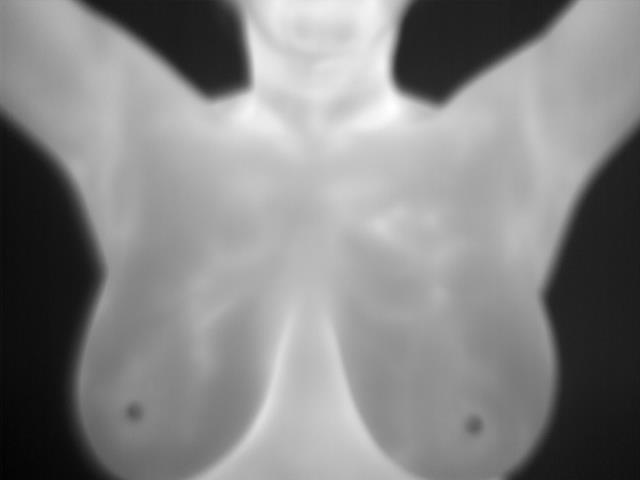

Dimensions (480, 640, 3)


In [3]:
from IPython.display import Image as display_image
from PIL import Image
import glob
import numpy as np

for file in glob.glob("out_img/1/*"):
  image = display_image(file)
  display(image)
  print("Dimensions", np.asarray(Image.open(file)).shape)
  break

# Label Formatting

In [4]:
import json, glob

Y = dict()
diagnoses = list()
for file in glob.glob("backup/*"):
  with open(file, 'r') as f:
    idx = file.split("_")[1].split(".")[0]
    D = json.load(f)
    if D['diagnosis'] == 'Healthy':
      Y[int(idx)] = 0
    elif D['diagnosis'] == 'Sick':
      Y[int(idx)] = 1
    # throw out unknown diagnoses
  f.close()


Train/Val/Test Split (60/20/20)



In [5]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

SEED=1
np.random.seed(SEED)

# get patient index for pos/neg train/val/test split

Y_pos = np.array([idx for idx in Y if Y[idx]])
Y_neg = np.array([idx for idx in Y if not Y[idx]])
N_pos = len(Y_pos)
N_neg = len(Y_neg)

y_train_pos_idx = np.random.choice(Y_pos, int(N_pos*0.6), replace=False)
y_train_neg_idx = np.random.choice(Y_neg, int(N_neg*0.6), replace=False)
y_eval_pos_idx = [y for y in Y_pos if y not in y_train_pos_idx]
y_eval_neg_idx = [y for y in Y_neg if y not in y_train_neg_idx]
y_val_pos_idx = y_eval_pos_idx[:(len(y_eval_pos_idx)//2)]
y_test_pos_idx = y_eval_pos_idx[(len(y_eval_pos_idx)//2):]
y_val_neg_idx = y_eval_neg_idx[:(len(y_eval_neg_idx)//2)]
y_test_neg_idx = y_eval_neg_idx[(len(y_eval_neg_idx)//2):]

assert len(Y_pos) == (len(y_train_pos_idx) + len(y_val_pos_idx) + len(y_test_pos_idx))
assert len(Y_neg) == (len(y_train_neg_idx) + len(y_val_neg_idx) + len(y_test_neg_idx))

Xtrain = list()
Xtrain_pos, Xtrain_neg = list(), list()
for idx in tqdm(y_train_pos_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xtrain_pos.append(np.asarray(Image.open(file)))
for idx in tqdm(y_train_neg_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xtrain_neg.append(np.asarray(Image.open(file)))
ytrain = np.concatenate((np.ones(len(Xtrain_pos)), np.zeros((len(Xtrain_neg)))))
Xtrain = np.array((Xtrain_pos+Xtrain_neg))
print("train", Xtrain.shape, ytrain.shape)
del Xtrain_pos
del Xtrain_neg

Xval = list()
Xval_pos, Xval_neg = list(), list()
for idx in tqdm(y_val_pos_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xval_pos.append(np.asarray(Image.open(file)))
for idx in tqdm(y_val_neg_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xval_neg.append(np.asarray(Image.open(file)))
yval = np.concatenate((np.ones(len(Xval_pos)), np.zeros((len(Xval_neg)))))
Xval = np.array((Xval_pos+Xval_neg))
print("validation", Xval.shape, yval.shape)
del Xval_pos
del Xval_neg

Xtest = list()
Xtest_pos, Xtest_neg = list(), list()
for idx in tqdm(y_test_pos_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xtest_pos.append(np.asarray(Image.open(file)))
for idx in tqdm(y_test_neg_idx):
  for file in glob.glob("out_img/"+str(idx)+"/*"):
    Xtest_neg.append(np.asarray(Image.open(file)))
ytest = np.concatenate((np.ones(len(Xtest_pos)), np.zeros((len(Xtest_neg)))))
Xtest = np.array((Xtest_pos+Xtest_neg))
print("test", Xtest.shape, ytest.shape)
del Xtest_pos
del Xtest_neg


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

train (3813, 480, 640, 3) (3813,)


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

validation (1399, 480, 640, 3) (1399,)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

test (1422,) (1422,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Model Training

In [6]:
import torch
import numpy as np
import os, time, random, sys, math
import torch.optim as optim
import torch.nn as nn
import tqdm.notebook as tq
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import DataLoader
from sklearn.metrics import average_precision_score, f1_score
import torchvision.models as models

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.329, 0.324, 0.325])

class ImgDataset(torch.utils.data.Dataset):
  '''
    Torch data loading class.
    Arguments:
      img - numpy array of images
      label - Torch tensor of image labels
      transform - Torch composed transformations (default: resize to 64x64)
  '''
  def __init__(self, img, label, transform=None):
    self.X = img
    self.Y = label
    if transform:
      self.transform = transform
    else:
      self.transform = torchvision.transforms.Compose([transforms.ToPILImage(),
                                                       transforms.Resize((128, 128)),
                                                       transforms.ToTensor(),
                                                       normalize])
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img = self.transform(self.X[idx])
    return img, self.Y[idx]


def load_data(BATCH_SIZE, ytrain, yval, ytest, Xtrain, Xval, Xtest):
  # load into numpy array
  ytrain = torch.from_numpy(ytrain.flatten()).long()
  yval = torch.from_numpy(yval.flatten()).long()
  ytest = torch.from_numpy(ytest.flatten()).long()
  # load into dataset
  transform_train = torchvision.transforms.Compose([transforms.ToPILImage(),
                                              transforms.Resize((128, 128)),
                                              #transforms.RandomVerticalFlip(0.5),
                                              #transforms.RandomHorizontalFlip(0.5),
                                              transforms.ToTensor()])
  train_data = ImgDataset(Xtrain, ytrain)
  val_data = ImgDataset(Xval, yval)
  test_data = ImgDataset(Xtest, ytest)
  # load batches
  train_dl = DataLoader(train_data, BATCH_SIZE, shuffle = True, num_workers = 2, pin_memory = True)
  val_dl = DataLoader(val_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  test_dl = DataLoader(test_data, BATCH_SIZE, num_workers = 2, pin_memory = True)
  return train_dl, val_dl, test_dl

def calculate_accuracy(fx, y):
  preds = fx.max(1, keepdim=True)[1]
  correct = preds.eq(y.view_as(preds)).sum()
  acc = correct.float()/preds.shape[0]
  return acc

def calculate_f1(fx, y):
  preds = fx.max(1, keepdim=True)[1]
  return f1_score(y.cpu(), preds.cpu())

def train(model, device, iterator, optimizer, criterion, scheduler=None):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x, y) in tq.tqdm(iterator, leave=False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    fx = model(x)
    loss = criterion(fx, y)
    acc = calculate_accuracy(fx, y)
    loss.backward()
    optimizer.step()
    if scheduler:
      scheduler.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, device, iterator, criterion, scheduler=None):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in tq.tqdm(iterator, leave=False):
      x = x.to(device)
      y = y.to(device)
      fx = model(x)
      loss = criterion(fx, y)
      acc = calculate_accuracy(fx, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
    if scheduler:
      scheduler.step(epoch_loss/len(iterator))
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, 10) 

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2 
        out = self.maxpool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(num_classes=2)
#model = CNNModel()
model.to(device)
summary(model, (3, 480, 480))

optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.14, 0.86], dtype=torch.float).to(device))
EPOCHS = 50
MODEL_NAME = 'sharknet.pt'
SAVE_DIR = "drive/MyDrive/"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
train_iterator, val_iterator, test_iterator = load_data(BATCH_SIZE=64, 
                                                        ytrain=ytrain, 
                                                        yval=yval, 
                                                        ytest=ytest, 
                                                        Xtrain=Xtrain, 
                                                        Xval=Xval, 
                                                        Xtest=Xtest)

best_valid_loss = float('inf')
time_curr = time.time()
history = dict()
# create save directory
if not os.path.isdir(f'{SAVE_DIR}'):
  os.makedirs(f'{SAVE_DIR}')
train_acc_list, val_acc_list, train_loss_list, val_loss_list = list(), list(), list(), list()

for epoch in range(EPOCHS):
  train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, device, val_iterator, criterion, scheduler)
  train_acc_list.append(train_acc)
  val_acc_list.append(valid_acc)
  train_loss_list.append(train_loss)
  val_loss_list.append(valid_loss)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

  print("|Epoch: {0:d} | Train loss: {1:.3f} | Train Acc: {2:.2f}% | Val Loss : {3:.3f} | Val Acc: {4:.2f}% | Time used: {5:d}s |".format(epoch+1,
      train_loss, train_acc*100, valid_loss, valid_acc*100, int(time.time()-time_curr)))
  history[epoch] = [train_loss, valid_loss]

  time_curr = time.time()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 240, 240]           9,408
       BatchNorm2d-2         [-1, 64, 240, 240]             128
              ReLU-3         [-1, 64, 240, 240]               0
         MaxPool2d-4         [-1, 64, 120, 120]               0
            Conv2d-5         [-1, 64, 120, 120]          36,864
       BatchNorm2d-6         [-1, 64, 120, 120]             128
              ReLU-7         [-1, 64, 120, 120]               0
            Conv2d-8         [-1, 64, 120, 120]          36,864
       BatchNorm2d-9         [-1, 64, 120, 120]             128
             ReLU-10         [-1, 64, 120, 120]               0
       BasicBlock-11         [-1, 64, 120, 120]               0
           Conv2d-12         [-1, 64, 120, 120]          36,864
      BatchNorm2d-13         [-1, 64, 120, 120]             128
             ReLU-14         [-1, 64, 1

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 1 | Train loss: 0.433 | Train Acc: 62.87% | Val Loss : 0.777 | Val Acc: 51.08% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 2 | Train loss: 0.244 | Train Acc: 84.35% | Val Loss : 1.218 | Val Acc: 53.70% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 3 | Train loss: 0.143 | Train Acc: 91.64% | Val Loss : 0.741 | Val Acc: 86.39% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 4 | Train loss: 0.097 | Train Acc: 94.27% | Val Loss : 0.644 | Val Acc: 85.16% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 5 | Train loss: 0.065 | Train Acc: 97.03% | Val Loss : 0.992 | Val Acc: 86.53% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 6 | Train loss: 0.032 | Train Acc: 98.70% | Val Loss : 1.891 | Val Acc: 53.14% | Time used: 76s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 7 | Train loss: 0.014 | Train Acc: 99.51% | Val Loss : 0.643 | Val Acc: 84.28% | Time used: 77s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 8 | Train loss: 0.007 | Train Acc: 99.90% | Val Loss : 0.749 | Val Acc: 78.65% | Time used: 76s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

|Epoch: 9 | Train loss: 0.004 | Train Acc: 99.97% | Val Loss : 0.723 | Val Acc: 80.90% | Time used: 76s |


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Saliency Map

0.06111594


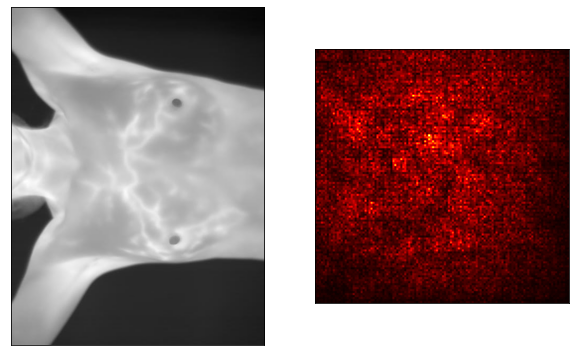

In [34]:
import matplotlib.pyplot as plt
import torch.nn.functional as nnf

train_iterator, val_iterator, test_iterator = load_data(BATCH_SIZE=256, 
                                                        ytrain=ytrain, 
                                                        yval=yval, 
                                                        ytest=ytest, 
                                                        Xtrain=Xtrain, 
                                                        Xval=Xval, 
                                                        Xtest=Xtest)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = 'sharknet.pt'
SAVE_DIR = "drive/MyDrive/"
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_NAME)
model = models.resnet18(num_classes=2)
model.load_state_dict(torch.load("sharknet.pt"))
#model.to(device)

import numpy as np
import matplotlib.pyplot as plt

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.329, 0.324, 0.325])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    transform = torchvision.transforms.Compose([transforms.ToPILImage(),
                                                       transforms.Resize((128, 128)),
                                                       transforms.ToTensor(),
                                                normalize])

    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    prob = nnf.softmax(preds, dim=1)
    print(prob.detach().numpy()[0][1])
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
      input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.savefig("cancer.png", dpi=300)

#img = torch.from_numpy(np.asarray(Image.open("test.jpeg")).T)

saliency(torch.from_numpy(Xtrain[0].T), model)
#saliency(img, model)